## Sorting out the Euler Rotation Order confusion
There exists a number of euler rotation angle sequences. Take a look at [Wikipedia's Euler Angles Entry](https://en.wikipedia.org/wiki/Euler_angles). And [this](https://www.princeton.edu/~stengel/MAE331Lecture8.pdf) is a better resource. The notation for the angles are

Roll: $\phi$
Pitch: $\theta$
Yaw: $\psi$

When denoted as X1, Y2, Z3, the roll, pitch, yaw would correspond to rotations about x, y, z respectively. 

A proper Euler angle is not what we commonly use in robotics, the proper Euler angles start and end with rotations about the same axis. The Tait-Bryan angles though are the ones where rotations are done about the three axes. So what we use normally are the Tait-Bryan angles, even though they generally are referred to Euler angles. 

The usual order used to transform between earth to body frame is the Tait-Bryan X1Y2Z3 convention but reversed

In [2]:
from sympy import init_printing
init_printing(use_latex=True)
from sympy import *
from sympy.abc import theta, phi, psi
# dir(abc)

In [3]:
#iR denotes rotation from body to inertial reference frame => iV = iRx bV 
bRx = rot_axis1(phi) # Rotation around x axis - roll
bRy = rot_axis2(theta) # Rotation around y axis - pitch
bRz = rot_axis3(psi) # Rotation around z axis - yaw

# bR denotes rotation from inertial to body frame
iRx = rot_axis1(-phi) # Rotation around x axis - roll
iRy = rot_axis2(-theta) # Rotation around y axis - pitch
iRz = rot_axis3(-psi) # Rotation around z axis - yaw

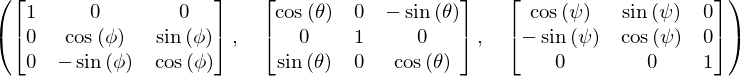

In [4]:
bRx, bRy, bRz

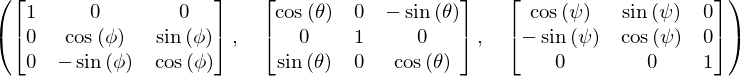

In [5]:
bRx, bRy, bRz

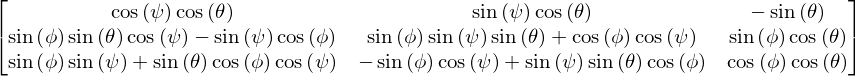

In [6]:
# The order of rotation between inertial to body frame would be
# iR = iRroll iRpitch iRyaw = iRx iRy iRz - Tait-Bryan 3-2-1 convention
bR = bRx*bRy*bRz
bR


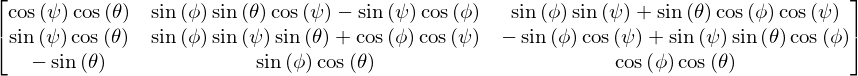

In [7]:
# And the reverse: from body frame to inertial frame - Z3Y2X1
# This corresponds to 
iR = iRz * iRy * iRx # equivalent to bR.inv()
iR

In [8]:
# simplify(bR.inv())

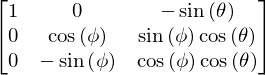

In [9]:
# Matrix Jko from Antonelli which expresses Jacobian for v2 =Jko * eta2 (eq2.2). 
# This is based on the roll, pitch, yaw convention : x(phi) y(theta) z(psi) order.
# TODO: figure out the control convention and write it out. 
Jko = Matrix([[1, 0, -sin(theta)], [0, cos(phi), cos(theta)*sin(phi)], [0, -sin(phi), cos(theta)*cos(phi)]])
Jko

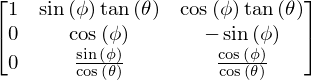

In [10]:
Jko_inv = Jko.inv()
simplify(Jko_inv)

In [11]:
# The rotation matrix that expresses the body-fixed velocities to earth frame is 
Je1 = Matrix.hstack(bR,zeros(3,3))
Je2 = Matrix.hstack(zeros(3,3), Jko)
Je = Matrix.vstack(Je1, Je2)

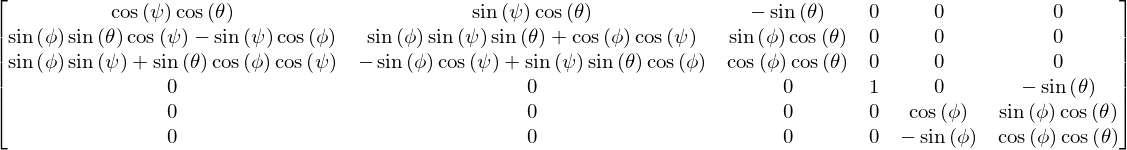

In [12]:
Je

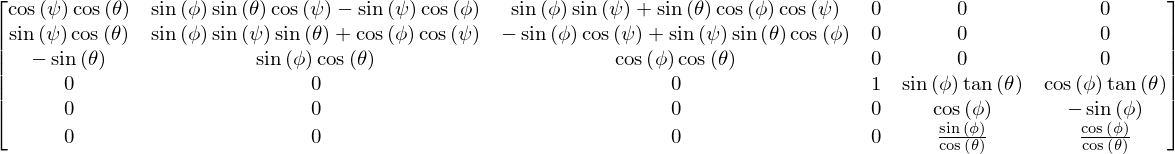

In [13]:
Je_inv = simplify(Je.inv()) # Similar to creating a block matrix with iR and Jko_inv instead
Je_inv

In [14]:
# test = utilities.lambdify((phi, psi, theta), Je)

In [15]:
# Let's convert our Je_inv matrix to a numpy array expression so we can copy and paste into our code
# First let's sub the symbols
roll_, pitch_, yaw_ = symbols("roll_ pitch_ yaw_")
Je_inv_sub = Je_inv.subs([(phi, roll_), (theta, pitch_), (psi, yaw_)])
import numpy as np
np.array(Je_inv_sub.tolist()) # remember to change expression

array([[cos(pitch_)*cos(yaw_),
        sin(pitch_)*sin(roll_)*cos(yaw_) - sin(yaw_)*cos(roll_),
        sin(pitch_)*cos(roll_)*cos(yaw_) + sin(roll_)*sin(yaw_), 0, 0, 0],
       [sin(yaw_)*cos(pitch_),
        sin(pitch_)*sin(roll_)*sin(yaw_) + cos(roll_)*cos(yaw_),
        sin(pitch_)*sin(yaw_)*cos(roll_) - sin(roll_)*cos(yaw_), 0, 0, 0],
       [-sin(pitch_), sin(roll_)*cos(pitch_), cos(pitch_)*cos(roll_), 0,
        0, 0],
       [0, 0, 0, 1, sin(roll_)*tan(pitch_), cos(roll_)*tan(pitch_)],
       [0, 0, 0, 0, cos(roll_), -sin(roll_)],
       [0, 0, 0, 0, sin(roll_)/cos(pitch_), cos(roll_)/cos(pitch_)]],
      dtype=object)

# Singularity
Now under certain configurations the Je_inv matrix is non-invertible, there is a division by cos(theta), so at pitch angles of -pi/2, pi/2 there is a division by zero. I instead need to represent the attitude rates using quaternions. The position linear velocity is fine, just the rates that need attention. A good online quaternion visualizer is found [here](http://quaternions.online/)

What I have is $v = [v_1 v_2] = [x y z \phi \theta \psi$
I need $\dot{\eta} = J_e({}^{I}R_B)v$
The Jacobian bottom right 3x3 matrix $J_{ko}$ is noninvertible at the singular position, so that's why we need to better use a quaternion to represent att rates

Let $\eta_q = \begin{bmatrix}\eta_1 \\ \epsilon \\ \eta \end{bmatrix} = \begin{bmatrix}{}^{I}x \\{}^{I}y\\ {}^{I}z\\ \epsilon\\ \eta \end{bmatrix}$ instead of $\eta= \begin{bmatrix}{}^{I}x \\{}^{I}y\\ {}^{I}z\\ {}^{I}\phi\\ {}^{I}\theta\\ {}^{I}\psi \end{bmatrix}$

We then can compute $v = J_{e,q}({}^{B}R_I) \dot{\eta}_q$
or $\dot{\eta}_q = J_{e,q}({}^{I}R_B)v $, I'm using the more intuite convention for $R$ in $J_e$
Then we can get $\dot{eta}$ from $\dot{\eta}_q$ by converting the quaternion represenation of rates to euler rates.  

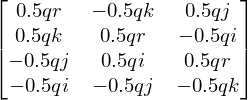

In [30]:
# We use ROS tf to convert between euler and quaternions, I just need to construct the Je,q matrix using quaternion_att, so both R and Jko need to be a function of quaternions
# but let's construct 
qr, qi, qj, qk = symbols("qr qi qj qk")
bRq = Matrix([[1-2*(qj*qj+qk*qk), 2*(qi*qj+qk*qr), 2*(qi*qk-qj*qr)],\
              [2*(qi*qj-qk*qr), 1 - 2*(qi*qi+qk*qk), 2*(qj*qk+qi*qr) ],\
              [2*(qi*qk+qj*qr), 2*(qj*qk-qi*qr), 1 - 2*(qi*qi+qj*qj)]])
iRq = Matrix([[1-2*(qj*qj+qk*qk), 2*(qi*qj-qk*qr), 2*(qi*qk+qj*qr)],\
              [2*(qi*qj+qk*qr), 1 - 2*(qi*qi+qk*qk), 2*(qj*qk-qi*qr) ],\
              [2*(qi*qk-qj*qr), 2*(qj*qk+qi*qr), 1 - 2*(qi*qi+qj*qj)]])
# Now the Jk,q
Jkoq = 0.5*Matrix([[qr, -qk, qj],[qk, qr, -qi],[-qj, qi, qr],[-qi, -qj, -qk]])
Jkoq

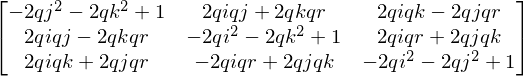

In [25]:
bRq

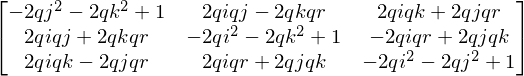

In [26]:
iRq

In [19]:
np.array(iRq.tolist()) 

array([[-2*qj**2 - 2*qk**2 + 1, 2*qi*qj - 2*qk*qr, 2*qi*qk + 2*qj*qr],
       [2*qi*qj + 2*qk*qr, -2*qi**2 - 2*qk**2 + 1, -2*qi*qr + 2*qj*qk],
       [2*qi*qk - 2*qj*qr, 2*qi*qr + 2*qj*qk, -2*qi**2 - 2*qj**2 + 1]],
      dtype=object)

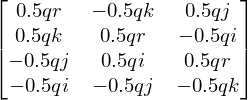

In [31]:
Jkoq

In [35]:
Je1q = Matrix.hstack(bRq,zeros(3,4))
Je2q = Matrix.hstack(zeros(3,3), 4*Jkoq.transpose())
Jeq = simplify(Matrix.vstack(Je1q, Je2q))
np.array(Jeq.tolist()) 

array([[-2*qj**2 - 2*qk**2 + 1, 2*qi*qj + 2*qk*qr, 2*qi*qk - 2*qj*qr, 0,
        0, 0, 0],
       [2*qi*qj - 2*qk*qr, -2*qi**2 - 2*qk**2 + 1, 2*qi*qr + 2*qj*qk, 0,
        0, 0, 0],
       [2*qi*qk + 2*qj*qr, -2*qi*qr + 2*qj*qk, -2*qi**2 - 2*qj**2 + 1, 0,
        0, 0, 0],
       [0, 0, 0, 2.0*qr, 2.0*qk, -2.0*qj, -2.0*qi],
       [0, 0, 0, -2.0*qk, 2.0*qr, 2.0*qi, -2.0*qj],
       [0, 0, 0, 2.0*qj, -2.0*qi, 2.0*qr, -2.0*qk]], dtype=object)

In [34]:
# This is from eq2.25 Antonelli
iR_sub = iR.subs([(phi, roll_), (theta, pitch_), (psi, yaw_)])
Je1q_inv = Matrix.hstack(iRq,zeros(3,3))
Je2q_inv = Matrix.hstack(zeros(4,3), Jkoq)
Jeq_inv = simplify(Matrix.vstack(Je1q_inv, Je2q_inv))
np.array(Jeq_inv.tolist()) 

array([[-2*qj**2 - 2*qk**2 + 1, 2*qi*qj - 2*qk*qr, 2*qi*qk + 2*qj*qr, 0,
        0, 0],
       [2*qi*qj + 2*qk*qr, -2*qi**2 - 2*qk**2 + 1, -2*qi*qr + 2*qj*qk, 0,
        0, 0],
       [2*qi*qk - 2*qj*qr, 2*qi*qr + 2*qj*qk, -2*qi**2 - 2*qj**2 + 1, 0,
        0, 0],
       [0, 0, 0, 0.5*qr, -0.5*qk, 0.5*qj],
       [0, 0, 0, 0.5*qk, 0.5*qr, -0.5*qi],
       [0, 0, 0, -0.5*qj, 0.5*qi, 0.5*qr],
       [0, 0, 0, -0.5*qi, -0.5*qj, -0.5*qk]], dtype=object)

In [22]:
p = np.array([1,2,3,4,5,6])
p[3:6]

array([4, 5, 6])

Propagating quaternion rate over time is not a straight forward matter, I don't know why the book has it that attitude change is represented in eta_dot. Check [this](https://www.ashwinnarayan.com/post/how-to-integrate-quaternions/) page on dealing with quaternions. 

---
So it turns out that the quaternion rates can be used to represent the system dynamics, and not to be integrated to find position at a point in time. Simulating the system will require euler angles. But I still need to answer the question of how to avoid singularity in the jacobian when pitch is -pi/2, pi/2